In [8]:
from datetime import datetime
import ccxt

import json
import numpy as np
import pandas as pd
from apscheduler.schedulers.blocking import BlockingScheduler


from bokeh.plotting import figure
from bokeh.io import push_notebook,show, output_notebook
from bokeh.models import HoverTool, Band, ColumnDataSource
output_notebook()

Loading BokehJS ...

In [2]:
credentials ={
            "apiKey":"62a05a9ccf9fd60001e2ff9e",
            "secret":"578687f6-5420-46d7-9b7a-26a737713cfb",
            "password":"3FiF$4sR6p5Y9fPnSNijL?HaGcd@A7"
}
session = ccxt.kucoin()

In [6]:
order_books = session.fetch_order_book('BTC/USDT')

bids = np.array(order_books['bids'])[:300]
asks = np.array(order_books['asks'])[:300]

OB_df = pd.DataFrame({'bids_price':bids[:,0],
                    'asks_price':asks[:len(bids[:,0]),0],
                        'bids_amount':bids[:,1],
                        'asks_amount':asks[:len(bids[:,0]),1],
                        'bids_volume':bids[:,1]*bids[:,0],
                        'asks_volume':asks[:len(bids[:,0]),1]*asks[:len(bids[:,0]),0],
            },
            dtype=float)
OB_df.head()

,bids_price,asks_price,bids_amount,asks_amount,bids_volume,asks_volume
0,19567.0,19567.1,3.415347,2.423578,66828.102576,47422.395823
1,19566.9,19567.2,0.005494,0.002837,107.496635,55.518799
2,19566.8,19567.3,0.002837,0.002837,55.517664,55.519083
3,19566.7,19567.4,0.002837,0.002220,55.517381,43.430040
4,19566.6,19567.5,0.015614,0.002837,305.503892,55.519650


/home/baptiste/windowsdisk/_sharedFS/Python/python-trading-bot/venv/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


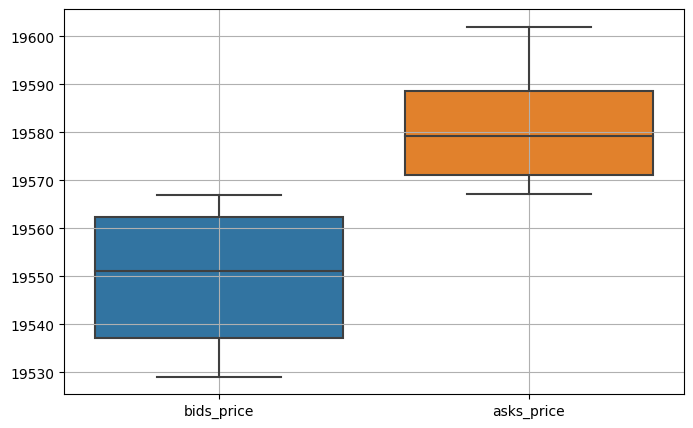

,bids_price,asks_price,bids_amount,asks_amount,bids_volume,asks_volume
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,19550.002000,19580.936000,0.478232,0.404061,9347.558024,7913.304422
std,12.811973,10.675371,0.927269,0.827168,18120.536601,16203.499702
min,19529.100000,19567.100000,0.000016,0.000094,0.304026,1.842541
25%,19537.150000,19571.050000,0.003121,0.005949,61.048294,116.466432
50%,19551.100000,19579.250000,0.100000,0.102109,1954.475000,2000.362248
75%,19562.425000,19588.525000,0.466578,0.507492,9113.279007,9940.588853
max,19567.000000,19602.000000,5.948700,5.948700,116197.146840,116570.130330


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1,1, figsize=(8, 5))

sns.boxplot(data=OB_df[['bids_price','asks_price']], ax=ax)

plt.grid()
plt.show()
OB_df.describe()

In [8]:
def cycle():
    order_books = session.fetch_order_book('BTC/USDT',)

    bids = np.array(order_books['bids'])[:300]
    asks = np.array(order_books['asks'])[:300]

    OB_df = pd.DataFrame({'bids_price':bids[:,0],
                        'asks_price':asks[:len(bids[:,0]),0],
                            'bids_amount':bids[:,1],
                            'asks_amount':asks[:len(bids[:,0]),1],
                            'bids_volume':bids[:,1]*bids[:,0],
                            'asks_volume':asks[:len(bids[:,0]),1]*asks[:len(bids[:,0]),0],
                },
                dtype=float)
    OB_df.head()

    print(f'DIFFERENCE (ask - bid) mean : {OB_df.asks_price.mean()- OB_df.bids_price.mean()} $')
    print(f'ASK mean : {OB_df.asks_price.mean()}')
    print(f'QTY DIFFERENCE : {OB_df.bids_amount.mean()-OB_df.asks_amount.mean()}')

    print(f'DIFFERENCE (ask - bid) median : {OB_df.asks_price.median()- OB_df.bids_price.median()} $')
    # spread == difference
    # more spread meaning low liquidity; slow time for price action
    # less spread meaning higher liquidity; faster price action
    print('==================================================================================================')
    total_vol_ask = OB_df['asks_volume'].sum()
    total_vol_bid = OB_df['bids_volume'].sum()
    #
    if total_vol_ask > total_vol_bid:
        print('CURRENT OB BOOKED AT SELLING')
        print('SELLING BOOKED VOLUME: ', total_vol_ask)
        print('BUYING BOOKED VOLUME: ', total_vol_bid)
        print('==================================================================================================')
    elif total_vol_bid > total_vol_ask:
        print('CURRENT OB BOOKED AT BUYING')
        print('BUYING BOOKED VOLUME: ', total_vol_bid)
        print('SELLING BOOKED VOLUME: ', total_vol_ask)
        print('==================================================================================================')
    elif total_vol_bid == total_vol_ask:
        print('CURRENT OB BOOKED AT NEURAL')
        print('BUYING BOOKED VOLUME: ', total_vol_bid)
        print('SELLING BOOKED VOLUME: ', total_vol_ask)
        print('==================================================================================================')


scheduler = BlockingScheduler()        
scheduler.add_job(cycle, trigger='cron', second='10',)
scheduler.start()

/home/baptiste/windowsdisk/_sharedFS/Python/python-trading-bot/venv/lib/python3.10/site-packages/apscheduler/util.py:436: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  return tzinfo.localize(dt)


DIFFERENCE (ask - bid) mean : 40.970000000001164 $
ASK mean : 19600.494
QTY DIFFERENCE : 0.23406227059999996
DIFFERENCE (ask - bid) median : 40.05000000000291 $
CURRENT OB BOOKED AT BUYING
BUYING BOOKED VOLUME:  1032682.02322371
SELLING BOOKED VOLUME:  576237.33791687


/home/baptiste/windowsdisk/_sharedFS/Python/python-trading-bot/venv/lib/python3.10/site-packages/apscheduler/util.py:436: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  return tzinfo.localize(dt)


DIFFERENCE (ask - bid) mean : 36.901999999998225 $
ASK mean : 19601.76
QTY DIFFERENCE : 0.08834058090000002
DIFFERENCE (ask - bid) median : 35.25 $
CURRENT OB BOOKED AT BUYING
BUYING BOOKED VOLUME:  978106.6899676021
SELLING BOOKED VOLUME:  807282.165592182


/home/baptiste/windowsdisk/_sharedFS/Python/python-trading-bot/venv/lib/python3.10/site-packages/apscheduler/util.py:436: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  return tzinfo.localize(dt)


DIFFERENCE (ask - bid) mean : 30.854000000002998 $
ASK mean : 19600.172000000002
QTY DIFFERENCE : 0.08004409620000003
DIFFERENCE (ask - bid) median : 30.099999999998545 $
CURRENT OB BOOKED AT BUYING
BUYING BOOKED VOLUME:  813955.351654725
SELLING BOOKED VOLUME:  658640.6071247878


/home/baptiste/windowsdisk/_sharedFS/Python/python-trading-bot/venv/lib/python3.10/site-packages/apscheduler/util.py:436: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  return tzinfo.localize(dt)


DIFFERENCE (ask - bid) mean : 38.94499999999971 $
ASK mean : 19593.242000000002
QTY DIFFERENCE : 0.28606209409999994
DIFFERENCE (ask - bid) median : 34.54999999999927 $
CURRENT OB BOOKED AT BUYING
BUYING BOOKED VOLUME:  1232895.945523996
SELLING BOOKED VOLUME:  675037.135895215


/home/baptiste/windowsdisk/_sharedFS/Python/python-trading-bot/venv/lib/python3.10/site-packages/apscheduler/util.py:436: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  return tzinfo.localize(dt)


DIFFERENCE (ask - bid) mean : 30.712000000003172 $
ASK mean : 19598.903000000002
QTY DIFFERENCE : 0.21229209299999996
DIFFERENCE (ask - bid) median : 29.5 $
CURRENT OB BOOKED AT BUYING
BUYING BOOKED VOLUME:  1031697.1714609991
SELLING BOOKED VOLUME:  617491.7129372559


KeyboardInterrupt: 

In [52]:
from datetime import datetime

SYMBOL = 'ETH/USDT'

df = pd.read_csv('./depot/orderbook.csv',)
df['timestamp'] = df.timestamp.apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ'))
df = df.set_index('timestamp')
df.drop(columns=['_id'], inplace=True)
df = df[df['symbol']==SYMBOL]
df['Direction'] = df.price_movement.apply(lambda x: 1 if x=='BUYING' else 0)
df.head()

,difference_ask_bid,exchange,mean_ask,mean_bid,median_ask,median_bid,price_movement,qty_difference,std_ask,std_bid,symbol,total_vol_ask,total_vol_bid,Direction
timestamp,,,,,,,,,,,,,,
2022-10-04 07:49:00,2.23,kucoin,1349.08,1346.85,1348.95,1346.84,BUYING,0.86818,0.784,0.610,ETH/USDT,693209.16,808825.97,1
2022-10-04 07:50:00,2.12,kucoin,1348.20,1346.08,1348.10,1346.16,BUYING,0.57472,0.640,0.694,ETH/USDT,787559.48,863439.62,1
2022-10-04 07:51:00,2.41,kucoin,1348.67,1346.26,1348.54,1346.31,SELLING,-3.21887,0.817,0.747,ETH/USDT,1157725.28,721978.54,0
2022-10-04 07:52:00,2.61,kucoin,1349.95,1347.33,1349.98,1347.44,BUYING,0.83632,0.708,0.766,ETH/USDT,576950.02,688405.84,1
2022-10-04 07:53:00,2.25,kucoin,1350.44,1348.19,1350.48,1348.24,BUYING,1.82398,0.577,0.713,ETH/USDT,673356.57,918004.27,1


In [42]:
from modules.Utils.utils import loadFromDB
cryptos = loadFromDB('ETH','5m')
cryptos = cryptos.loc[df.index[0]:df.index[-1]]
cryptos.head()

,Open,High,Low,Close,Volume,Timestamp
Date,,,,,,
2022-10-04 07:50:00,1347.08,1349.42,1346.39,1348.68,2297.0870,1664869800
2022-10-04 07:55:00,1348.68,1350.20,1348.67,1350.00,1933.6191,1664870100
2022-10-04 08:00:00,1349.99,1354.65,1349.13,1352.74,8089.3203,1664870400
2022-10-04 08:05:00,1352.73,1359.67,1352.44,1354.77,10465.7524,1664870700
2022-10-04 08:10:00,1354.78,1358.50,1354.25,1355.01,3809.8940,1664871000


In [53]:
from bokeh.plotting import figure
from bokeh.io import push_notebook,show, output_notebook
from bokeh.models import HoverTool, Band, ColumnDataSource
output_notebook()

p = figure(title=f"Order book", x_axis_label='time', y_axis_label='values',width=1500, height=600,)

p.add_tools(HoverTool(
    tooltips=[
    ("Price", "@y{0.00} $"),
], formatters={
        '$x': 'datetime',
        '$y' : 'printf',
    },
    mode='vline'
))
p.line(df.index, df.Direction, legend_label="qty_difference", line_width=2, )
#p.line(df.index, df.difference_ask_bid, legend_label="qty_difference", line_width=2, color='orange')
p.legend.location = "top_left"
show(p)

Loading BokehJS ...

In [51]:
from bokeh.plotting import figure
from bokeh.io import push_notebook,show, output_notebook
from bokeh.models import HoverTool, Band, ColumnDataSource
output_notebook()

p = figure(title=f"Order book", x_axis_label='time', y_axis_label='values',width=1500, height=600,)

p.add_tools(HoverTool(
    tooltips=[
    ("Price", "@y{0.00} $"),
], formatters={
        '$x': 'datetime',
        '$y' : 'printf',
    },
    mode='vline'
))
p.line(cryptos.index, cryptos.Close, legend_label="real data", line_width=2, )
p.legend.location = "top_left"
show(p)

Loading BokehJS ...